# GPVAE model

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from GP import *
from Models.GPVAE import GPVAE

import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)

In [2]:
# Load and preprocess the data
file_path = '../Data/RICO4_Dataset_processed.hdf'
df = pd.read_hdf(file_path)

# Filter heating data and downsample
df_h = df[df['temp_change_class'] == 'h']
def select_points(group):
    return group.iloc[::10]  # Select every 10th row
df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)

# Exclude specific intervals
excluded_intervals = [53, 5]
df_h_filtered = df_h[~df_h['interval'].isin(excluded_intervals)].reset_index(drop=True)
df_h = df_h_filtered

# Define RICO4Dataset
class RICO4Dataset(Dataset):
    def __init__(self, df_h):
        self.df_h = df_h
        self.unique_intervals = df_h['interval'].unique()

    def __len__(self):
        return len(self.unique_intervals)

    def __getitem__(self, idx):
        batch = self.unique_intervals[idx]
        id = self.df_h['interval'] == batch
        temp = torch.tensor(self.df_h[id]['B.RTD1'].to_numpy(), dtype=torch.float32)
        ti = torch.tensor(self.df_h[id]['time_within_interval'].to_numpy() / 240, dtype=torch.float32)
        x_batch = torch.cat((temp.unsqueeze(1), ti.unsqueeze(1)), axis=1)
        return x_batch

# Create dataset instance
dataset = RICO4Dataset(df_h)

# Split the dataset into above_20 and below_20
above_20_data = []
below_20_data = []

for idx in range(len(dataset)):
    x_batch = dataset[idx]
    starting_value = x_batch[0, 0].item()  # Get the starting value of B.RTD1
    if starting_value > 20:
        above_20_data.append(x_batch)
    else:
        below_20_data.append(x_batch)

# Define SubsetDataset
class SubsetDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create DataLoader instances
above_20_dataset = SubsetDataset(above_20_data)
below_20_dataset = SubsetDataset(below_20_data)

train_loader = DataLoader(above_20_dataset, batch_size=1, shuffle=True)  # Adjust batch_size as needed
val_loader = DataLoader(below_20_dataset, batch_size=1, shuffle=True)


/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_21965/1661409149.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)


In [3]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))

# Initialize the VAE
torch.manual_seed(1)
model = GPVAE(GP_inf = GP_inference(kernel),# GP_inference(kernel,mean_GP), 
              activation_decoder=nn.ReLU(),
              hidden_layers_encoder=[10])

In [4]:
gp_params = []
base_params = []

for name, param in model.named_parameters():
    if 'GP' in name:
        gp_params.append(param)  # Gaussian Process parameters
    else:
        base_params.append(param)  # Other parameters

base_lr = 0.001  # Learning rate for base parameters
gp_lr = 0.0001  # Learning rate for GP parameters
# Create separate parameter groups in the optimizer
opt = torch.optim.Adam([
    {'params': base_params, 'lr': base_lr},
    {'params': gp_params, 'lr': gp_lr}
])
opt.zero_grad()


In [5]:
t_uni=torch.tensor(
    [  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.]
)
t_uni

tensor([  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.])

Training Progress:   5%|▍         | 248/5000 [00:14<04:34, 17.28it/s]

Epoch 250:
  Training - Loss = 4.5053, KL = 0.3905, MSE = 4.5092, CE = 1.3537
  Validation - Loss = 33.3776, KL = 0.3913, MSE = 33.3815, CE = 1.3738
  Mean q_mu = 1.2682, Mean q_var = 0.7940


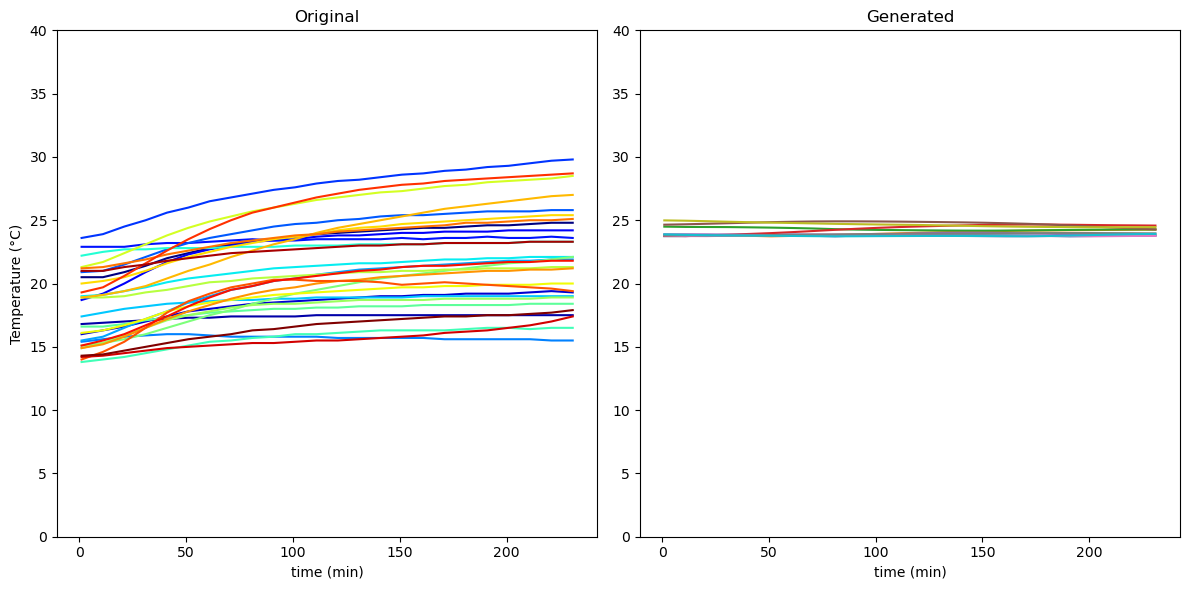

Training Progress:  10%|▉         | 498/5000 [00:29<04:22, 17.13it/s]

Epoch 500:
  Training - Loss = 4.3285, KL = 0.3288, MSE = 4.3318, CE = 1.1602
  Validation - Loss = 31.9297, KL = 0.3302, MSE = 31.9330, CE = 1.1754
  Mean q_mu = 1.7057, Mean q_var = 0.5308


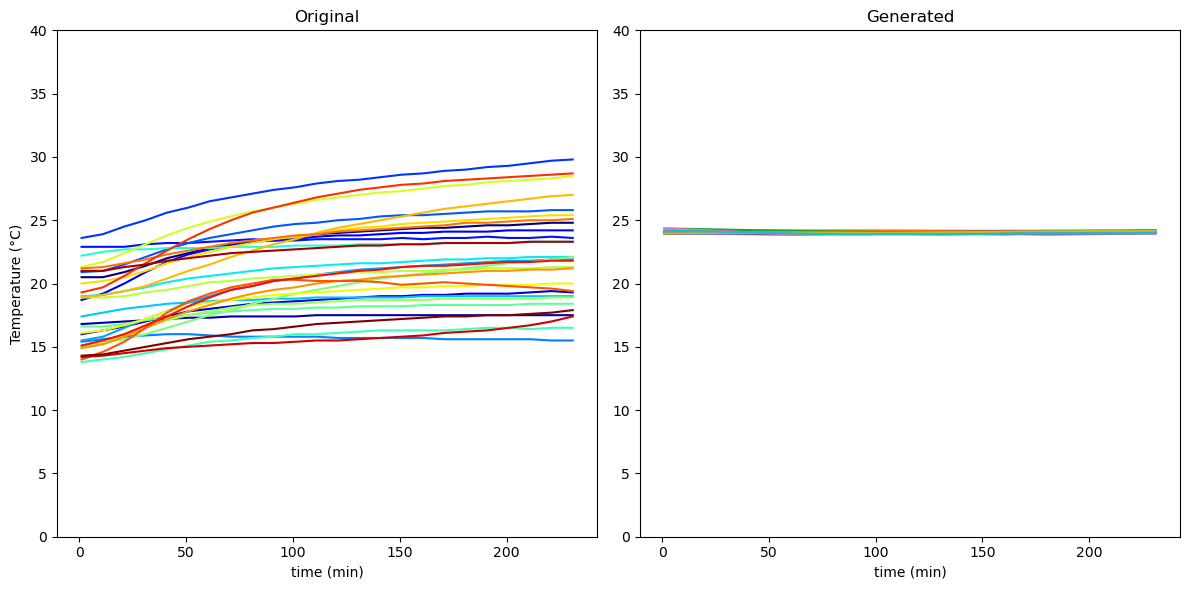

Training Progress:  15%|█▍        | 748/5000 [00:44<04:09, 17.02it/s]

Epoch 750:
  Training - Loss = 4.2471, KL = 0.3153, MSE = 4.2503, CE = 1.0260
  Validation - Loss = 32.9906, KL = 0.3168, MSE = 32.9937, CE = 1.0380
  Mean q_mu = 1.7058, Mean q_var = 0.4039


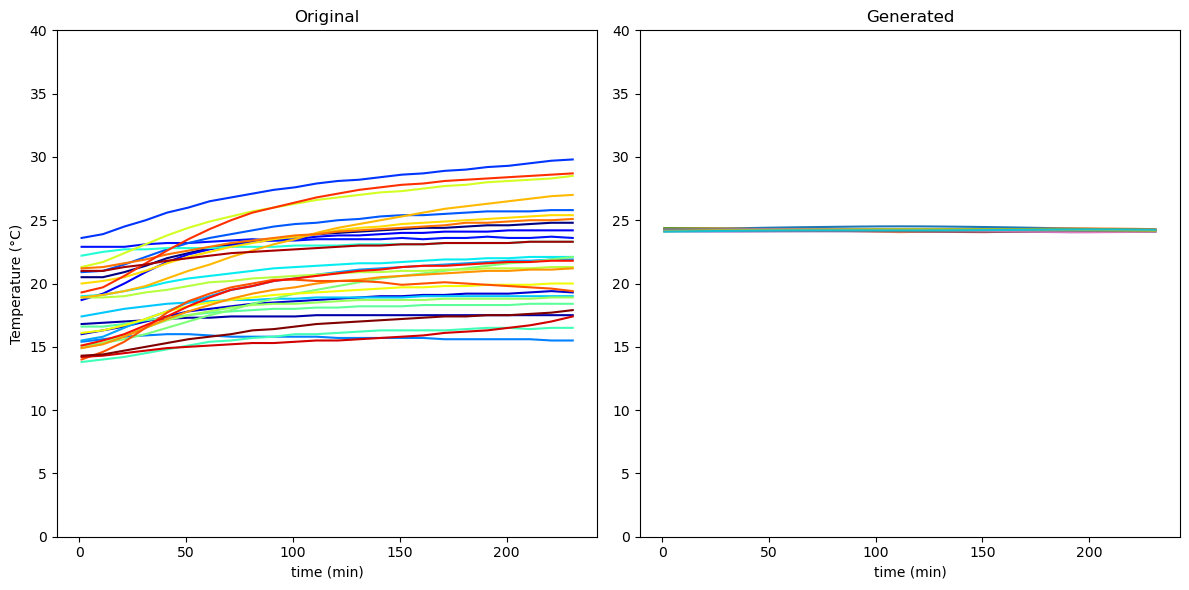

Training Progress:  20%|█▉        | 998/5000 [00:59<03:57, 16.86it/s]

Epoch 1000:
  Training - Loss = 4.2469, KL = 0.3196, MSE = 4.2501, CE = 0.9283
  Validation - Loss = 33.3170, KL = 0.3205, MSE = 33.3202, CE = 0.9382
  Mean q_mu = 1.5879, Mean q_var = 0.3319


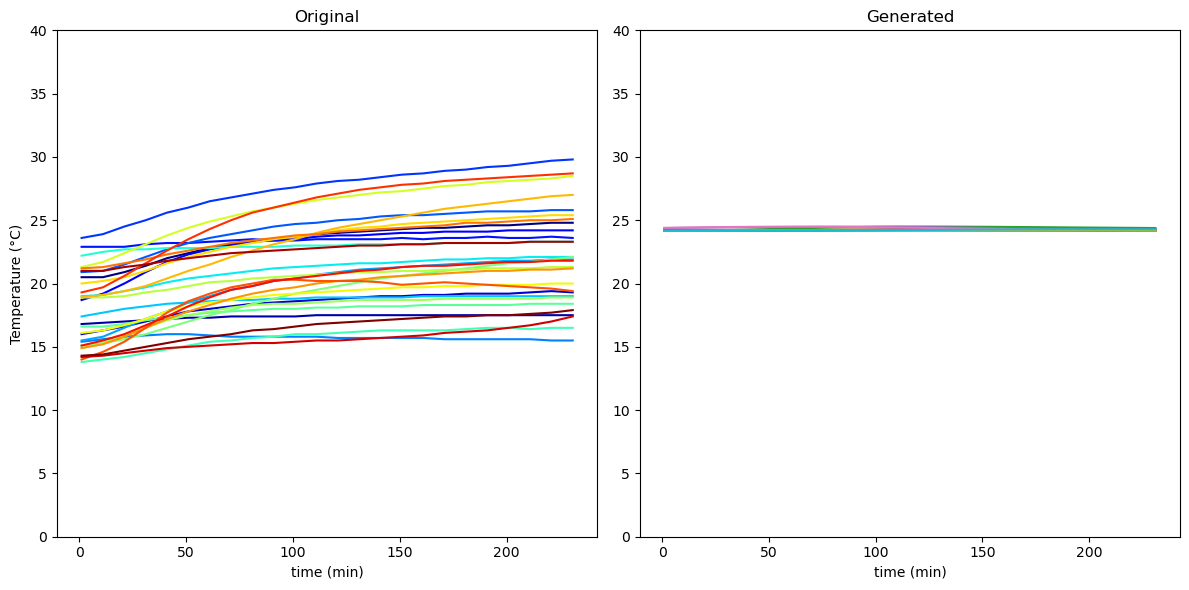

Training Progress:  25%|██▍       | 1248/5000 [01:14<03:44, 16.70it/s]

Epoch 1250:
  Training - Loss = 4.2920, KL = 0.3688, MSE = 4.2957, CE = 0.8262
  Validation - Loss = 33.2850, KL = 0.3692, MSE = 33.2887, CE = 0.8330
  Mean q_mu = 0.9610, Mean q_var = 0.2720


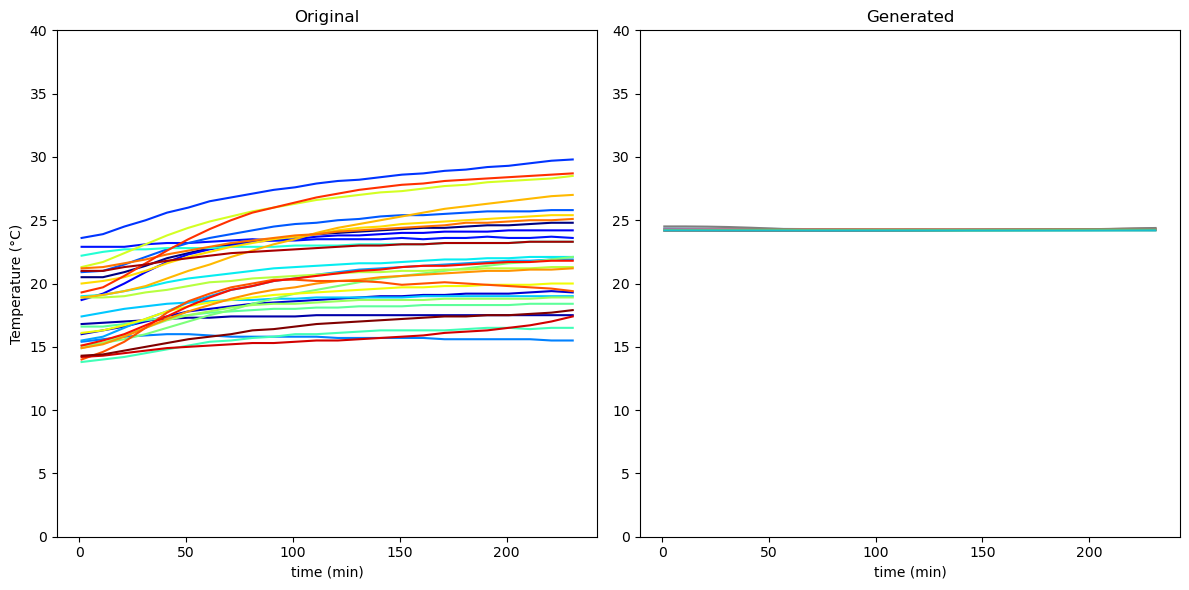

Training Progress:  30%|██▉       | 1498/5000 [01:29<03:28, 16.80it/s]

Epoch 1500:
  Training - Loss = 4.2725, KL = 0.3795, MSE = 4.2763, CE = 0.7040
  Validation - Loss = 33.0687, KL = 0.3802, MSE = 33.0725, CE = 0.7108
  Mean q_mu = 0.5908, Mean q_var = 0.2129


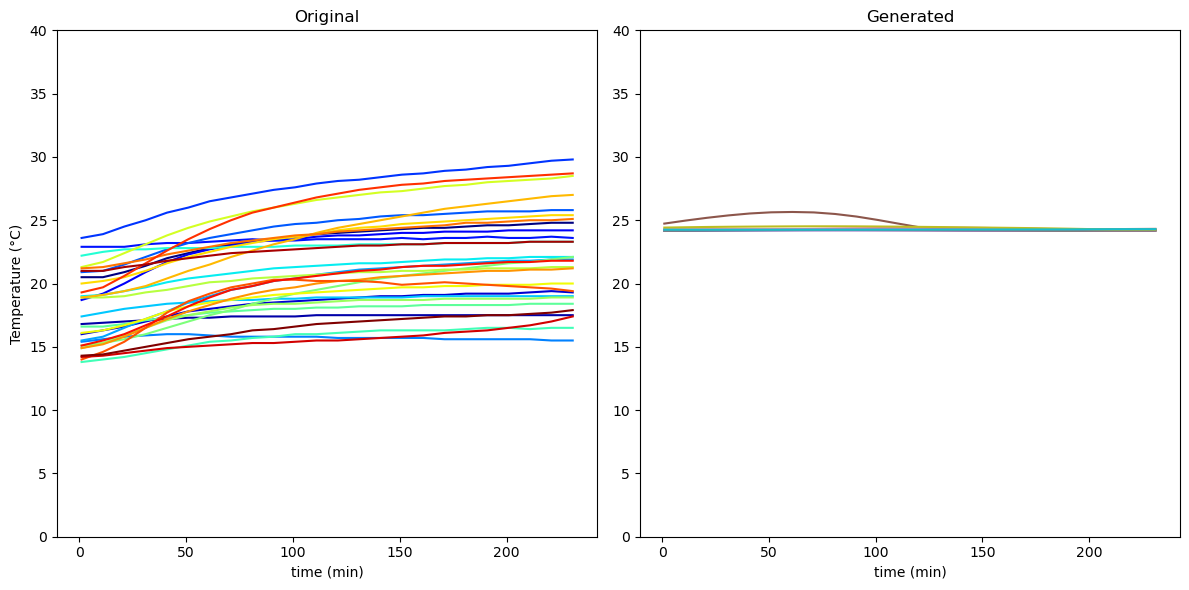

Training Progress:  35%|███▍      | 1748/5000 [01:44<03:10, 17.04it/s]

Epoch 1750:
  Training - Loss = 4.2943, KL = 0.3938, MSE = 4.2983, CE = 0.7152
  Validation - Loss = 33.7823, KL = 0.3939, MSE = 33.7863, CE = 0.7174
  Mean q_mu = 0.1999, Mean q_var = 0.2182


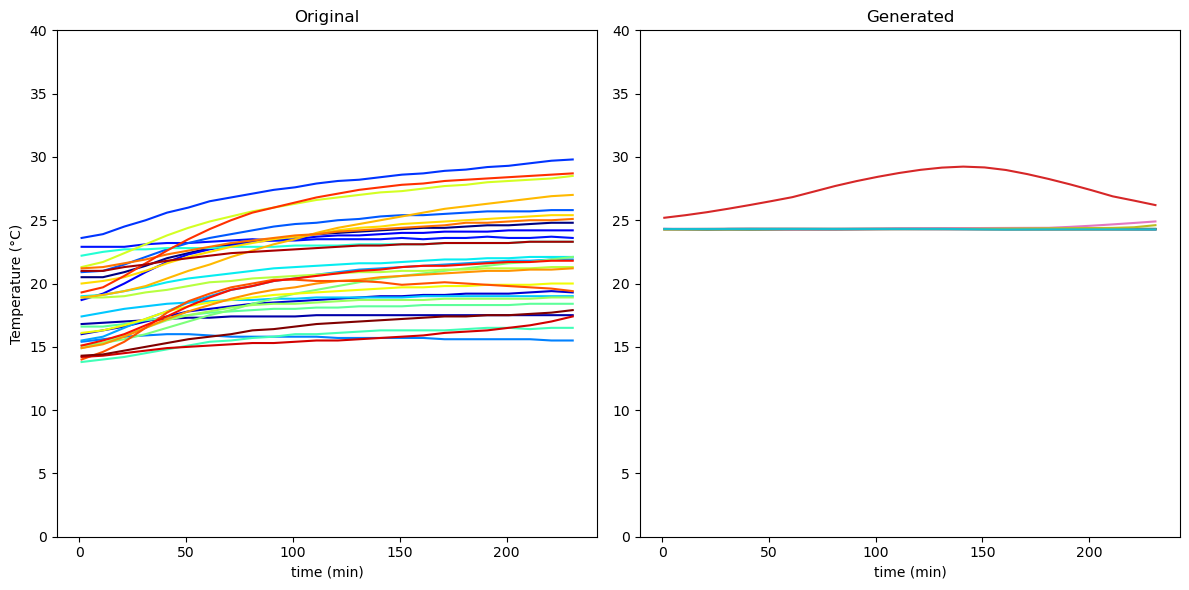

Training Progress:  40%|███▉      | 1998/5000 [02:00<03:11, 15.67it/s]

Epoch 2000:
  Training - Loss = 4.2889, KL = 0.3748, MSE = 4.2926, CE = 0.4771
  Validation - Loss = 32.5618, KL = 0.3746, MSE = 32.5655, CE = 0.4754
  Mean q_mu = 0.0969, Mean q_var = 0.1342


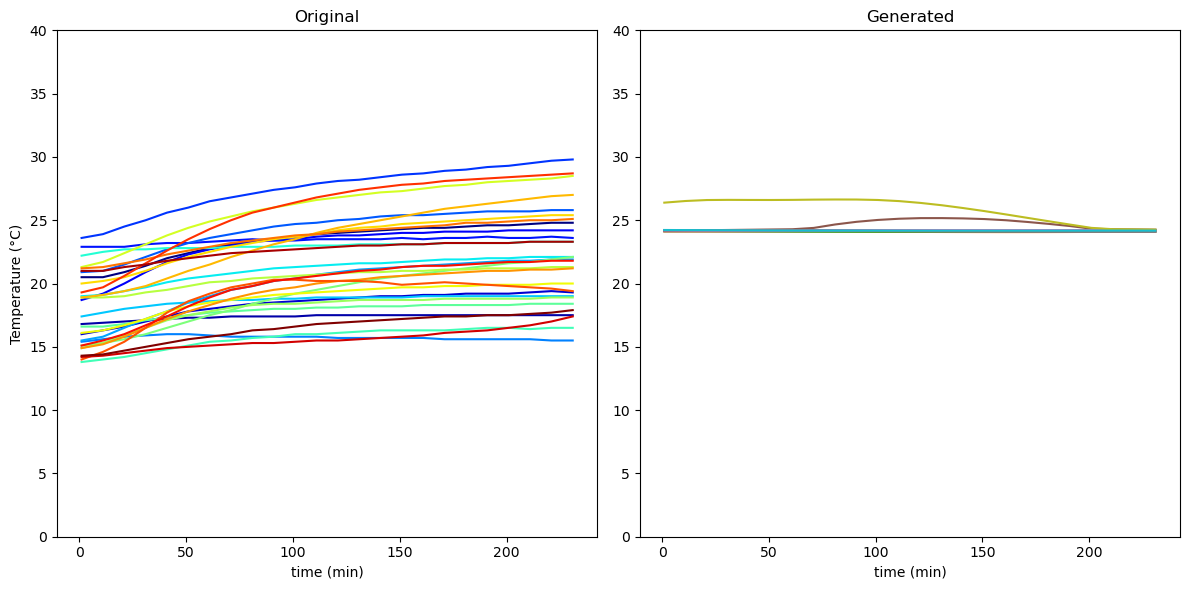

Training Progress:  45%|████▍     | 2248/5000 [02:14<02:41, 17.06it/s]

Epoch 2250:
  Training - Loss = 4.2367, KL = 0.3837, MSE = 4.2405, CE = 0.5095
  Validation - Loss = 33.0317, KL = 0.3871, MSE = 33.0355, CE = 0.5445
  Mean q_mu = -0.0014, Mean q_var = 0.1454


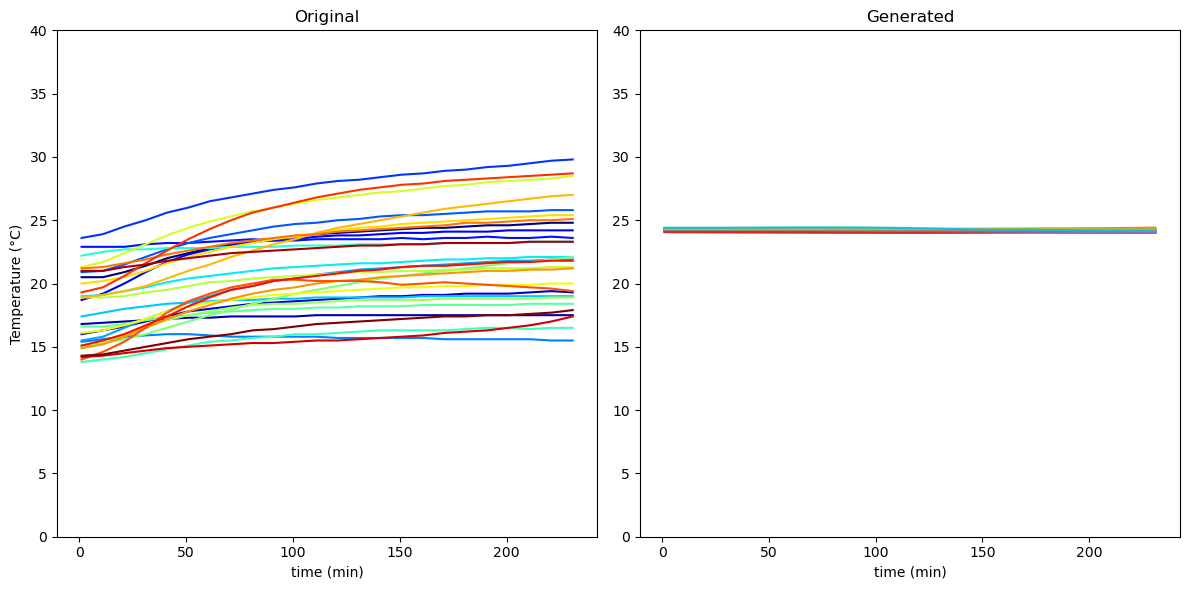

Training Progress:  50%|████▉     | 2498/5000 [02:29<02:29, 16.78it/s]

Epoch 2500:
  Training - Loss = 3.8005, KL = 0.3217, MSE = 3.8037, CE = -0.0091
  Validation - Loss = 27.6636, KL = 0.3249, MSE = 27.6668, CE = 0.0427
  Mean q_mu = -0.0545, Mean q_var = 0.0498


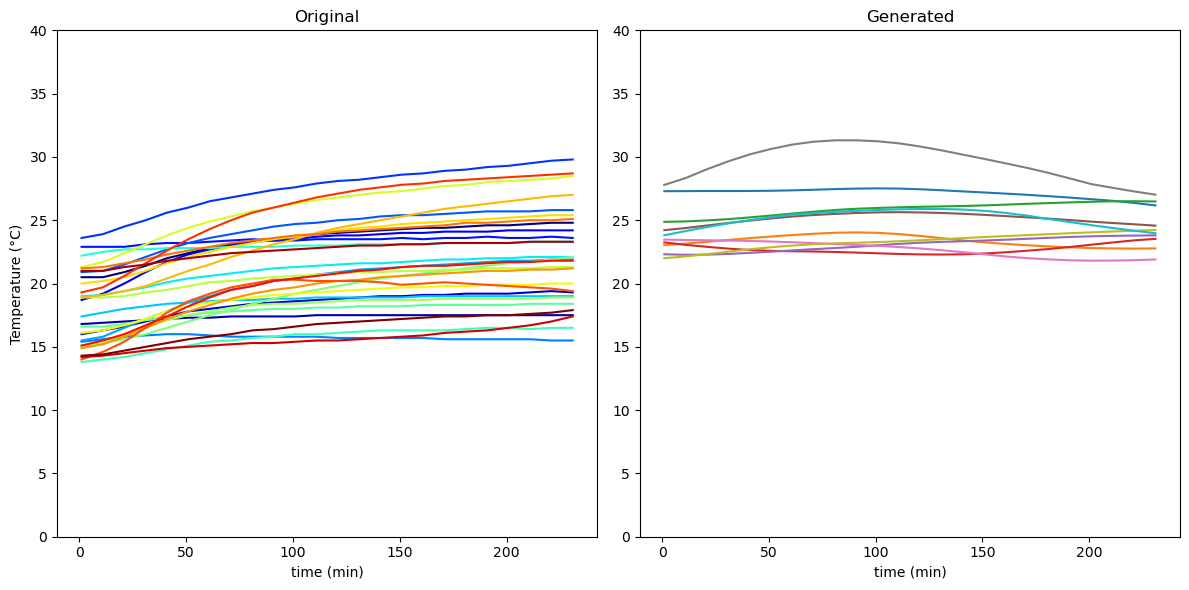

Training Progress:  55%|█████▍    | 2748/5000 [02:44<02:17, 16.43it/s]

Epoch 2750:
  Training - Loss = 2.3946, KL = 0.3117, MSE = 2.3977, CE = -0.0078
  Validation - Loss = 12.5071, KL = 0.3126, MSE = 12.5102, CE = 0.0868
  Mean q_mu = -0.2694, Mean q_var = 0.0498


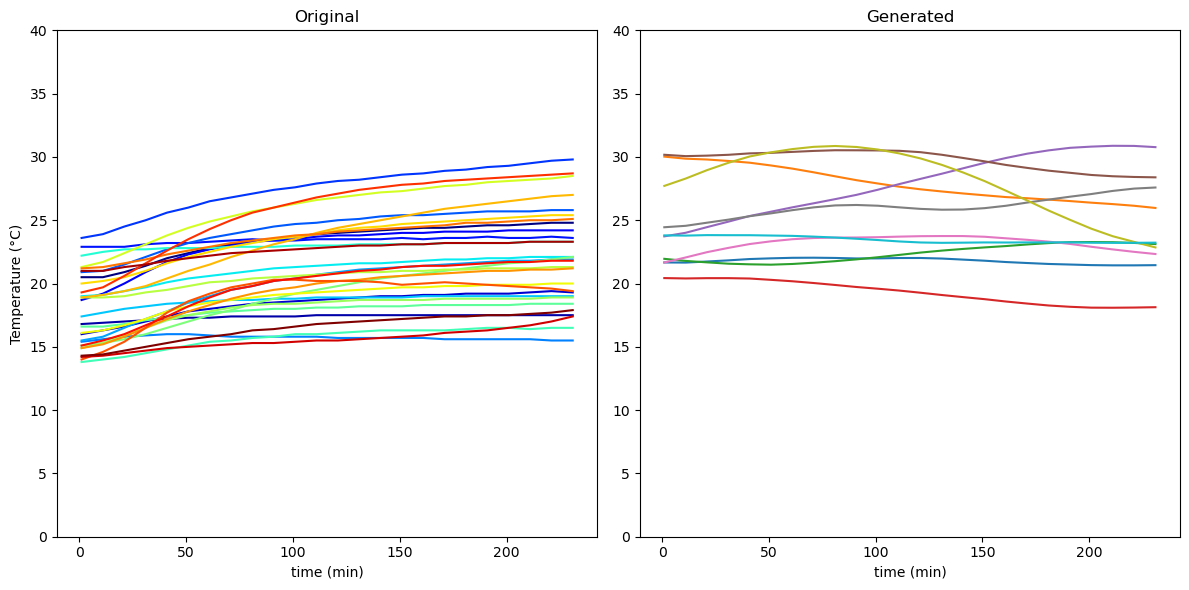

Training Progress:  60%|█████▉    | 2998/5000 [03:00<01:58, 16.88it/s]

Epoch 3000:
  Training - Loss = 1.4531, KL = 0.2996, MSE = 1.4561, CE = -0.0041
  Validation - Loss = 8.4719, KL = 0.2803, MSE = 8.4747, CE = 0.1227
  Mean q_mu = -0.2251, Mean q_var = 0.0498


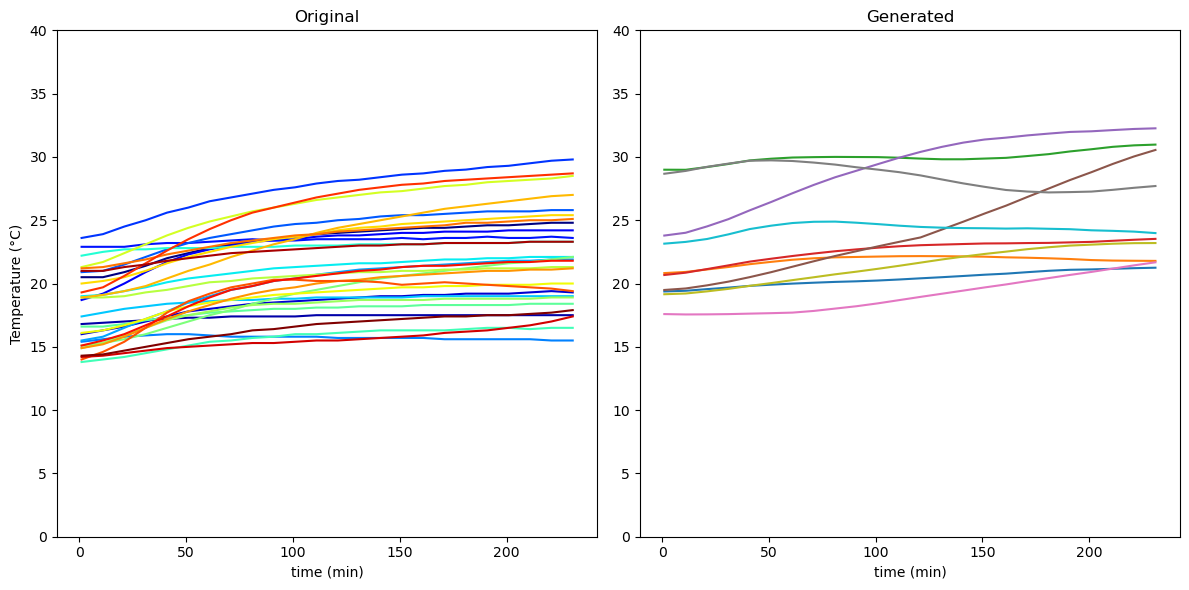

Training Progress:  65%|██████▍   | 3248/5000 [03:15<01:44, 16.80it/s]/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Epoch 3250:
  Training - Loss = 0.9207, KL = 0.2780, MSE = 0.9235, CE = 0.0026
  Validation - Loss = 5.1028, KL = 0.2298, MSE = 5.1051, CE = 0.1181
  Mean q_mu = -0.3328, Mean q_var = 0.0498


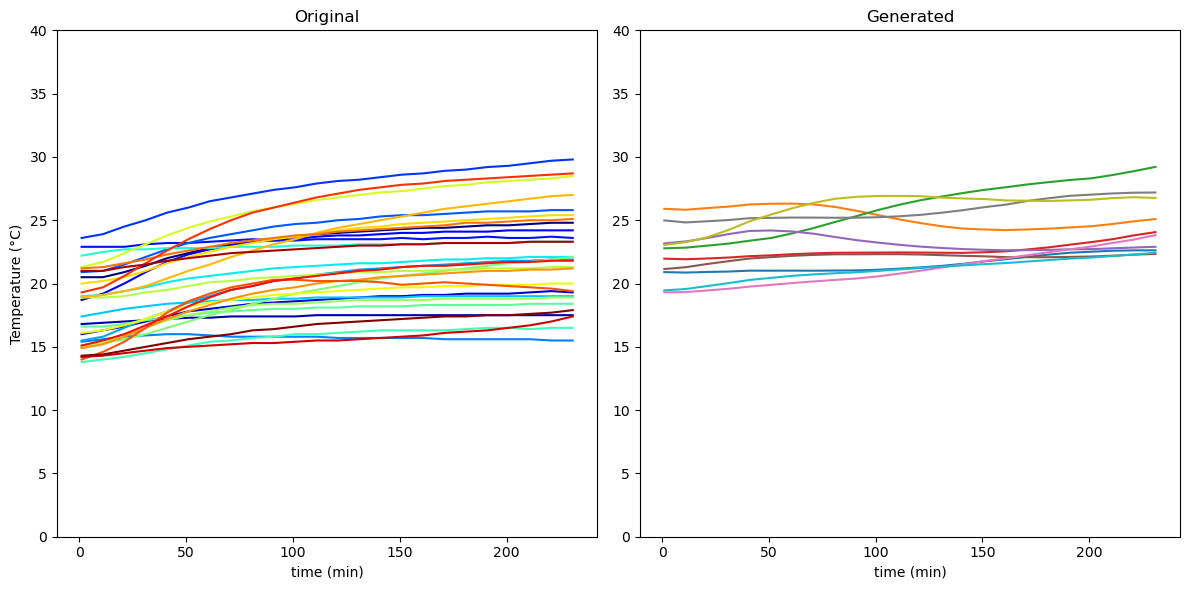

Training Progress:  70%|██████▉   | 3498/5000 [03:30<01:30, 16.65it/s]

Epoch 3500:
  Training - Loss = 0.6126, KL = 0.2489, MSE = 0.6151, CE = 0.0114
  Validation - Loss = 3.7111, KL = 0.1722, MSE = 3.7129, CE = 0.1563
  Mean q_mu = -0.4115, Mean q_var = 0.0498


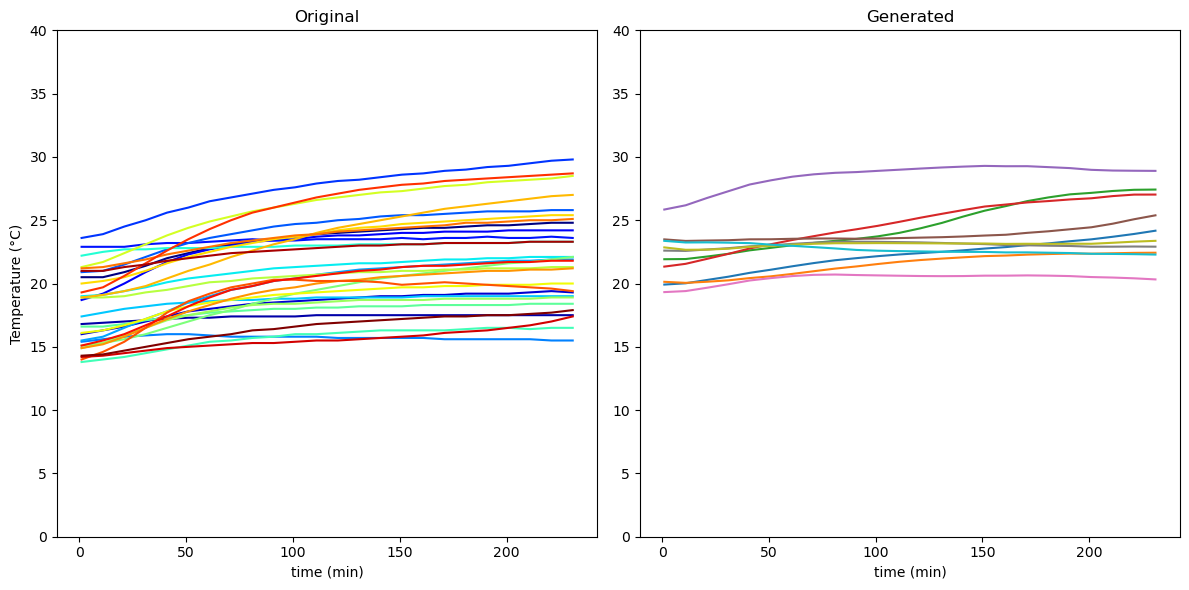

Training Progress:  75%|███████▍  | 3748/5000 [03:45<01:16, 16.31it/s]

Epoch 3750:
  Training - Loss = 0.3760, KL = 0.2128, MSE = 0.3781, CE = 0.0214
  Validation - Loss = 2.0498, KL = 0.0853, MSE = 2.0506, CE = 0.1801
  Mean q_mu = -0.4661, Mean q_var = 0.0498


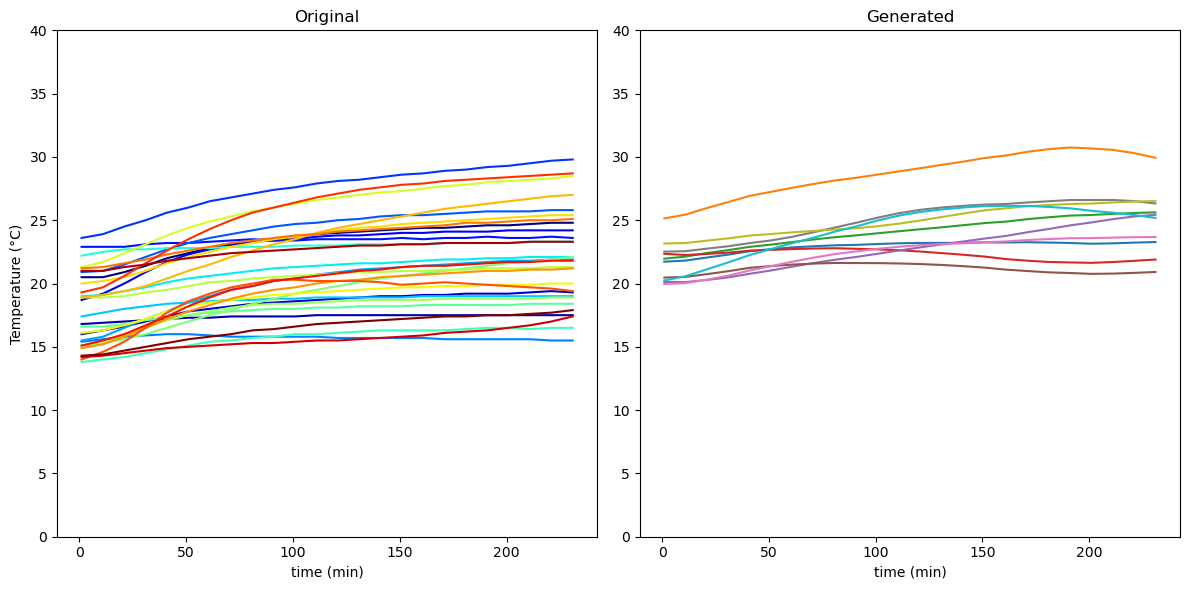

Training Progress:  80%|███████▉  | 3998/5000 [04:00<01:03, 15.89it/s]

Epoch 4000:
  Training - Loss = 0.2747, KL = 0.1733, MSE = 0.2764, CE = 0.0315
  Validation - Loss = 2.6436, KL = -0.0195, MSE = 2.6434, CE = 0.1704
  Mean q_mu = -0.4746, Mean q_var = 0.0498


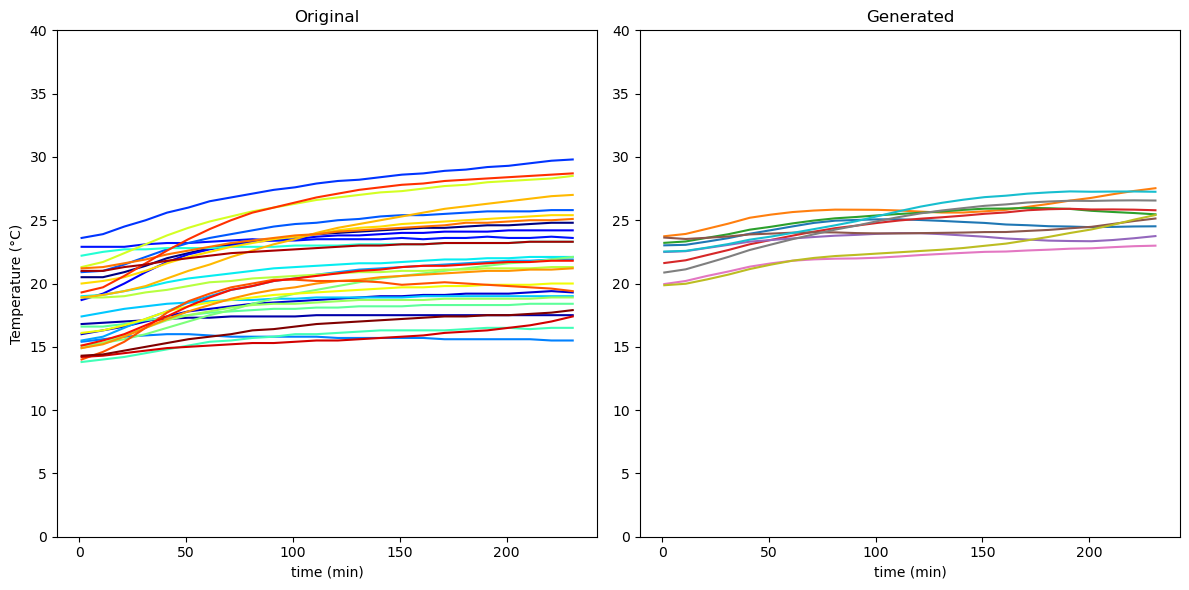

Training Progress:  85%|████████▍ | 4248/5000 [04:16<00:44, 16.79it/s]

Epoch 4250:
  Training - Loss = 0.1850, KL = 0.1310, MSE = 0.1863, CE = 0.0409
  Validation - Loss = 4.1885, KL = -0.1229, MSE = 4.1873, CE = 0.2250
  Mean q_mu = -0.3853, Mean q_var = 0.0498


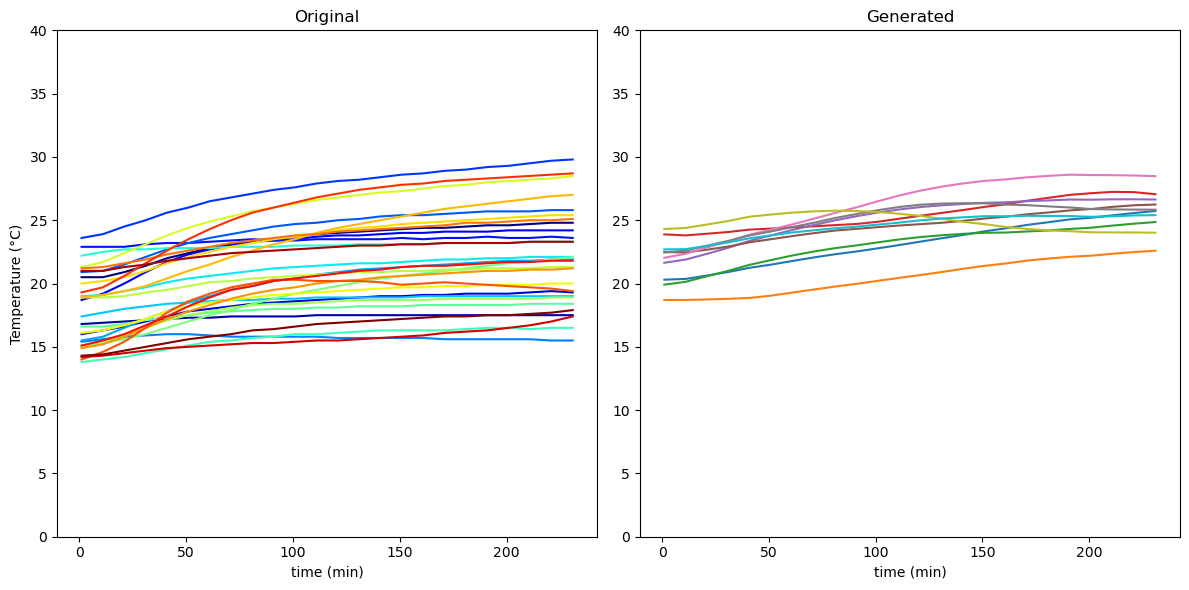

Training Progress:  90%|████████▉ | 4498/5000 [04:31<00:29, 16.77it/s]

Epoch 4500:
  Training - Loss = 0.1455, KL = 0.0881, MSE = 0.1463, CE = 0.0491
  Validation - Loss = 6.8902, KL = -0.2372, MSE = 6.8878, CE = 0.2739
  Mean q_mu = -0.3090, Mean q_var = 0.0498


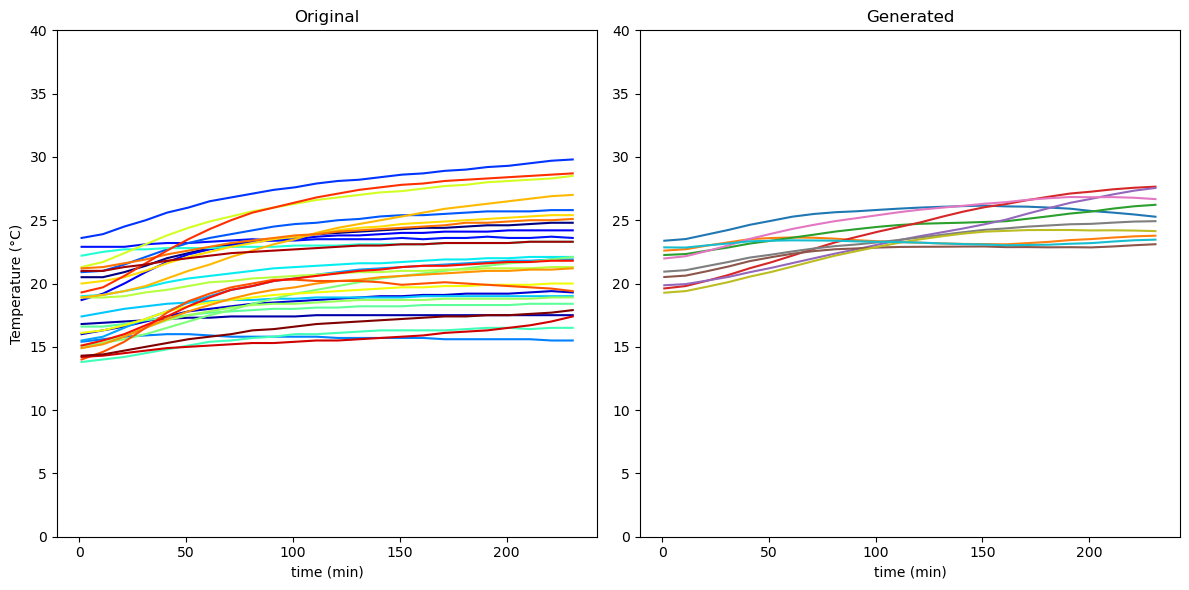

Training Progress:  95%|█████████▍| 4748/5000 [04:46<00:15, 16.76it/s]

Epoch 4750:
  Training - Loss = 0.1567, KL = 0.0491, MSE = 0.1572, CE = 0.0562
  Validation - Loss = 10.1535, KL = -0.3730, MSE = 10.1497, CE = 0.2444
  Mean q_mu = -0.3289, Mean q_var = 0.0498


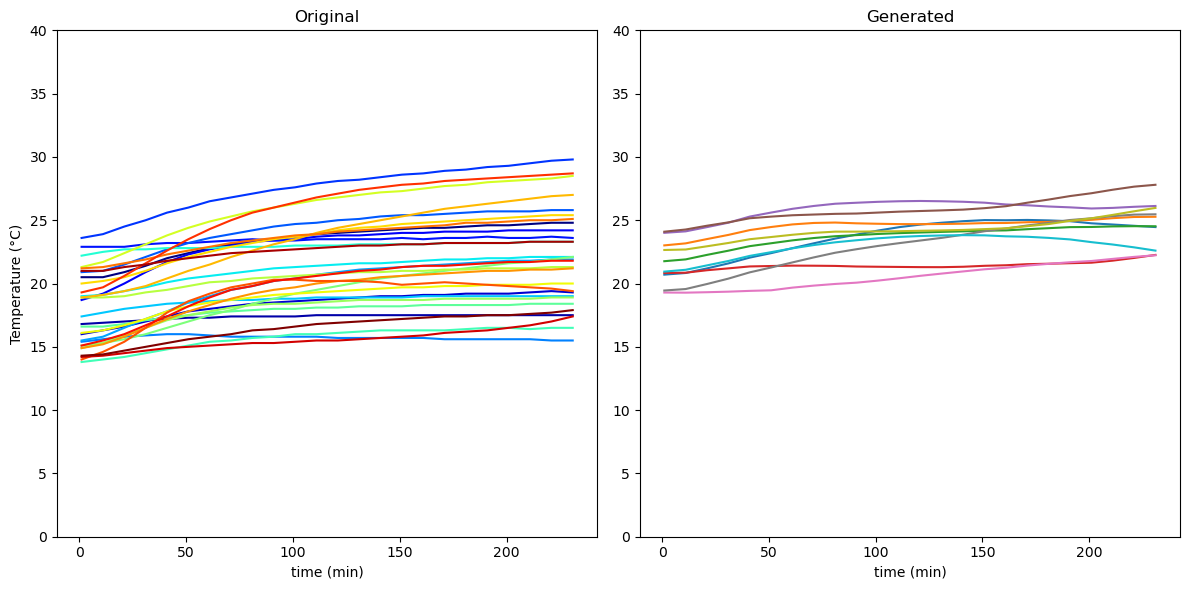

Training Progress: 100%|█████████▉| 4998/5000 [05:01<00:00, 16.85it/s]

Epoch 5000:
  Training - Loss = 0.1183, KL = 0.0119, MSE = 0.1184, CE = 0.0624
  Validation - Loss = 13.2091, KL = -0.4815, MSE = 13.2043, CE = 0.2751
  Mean q_mu = -0.3285, Mean q_var = 0.0498


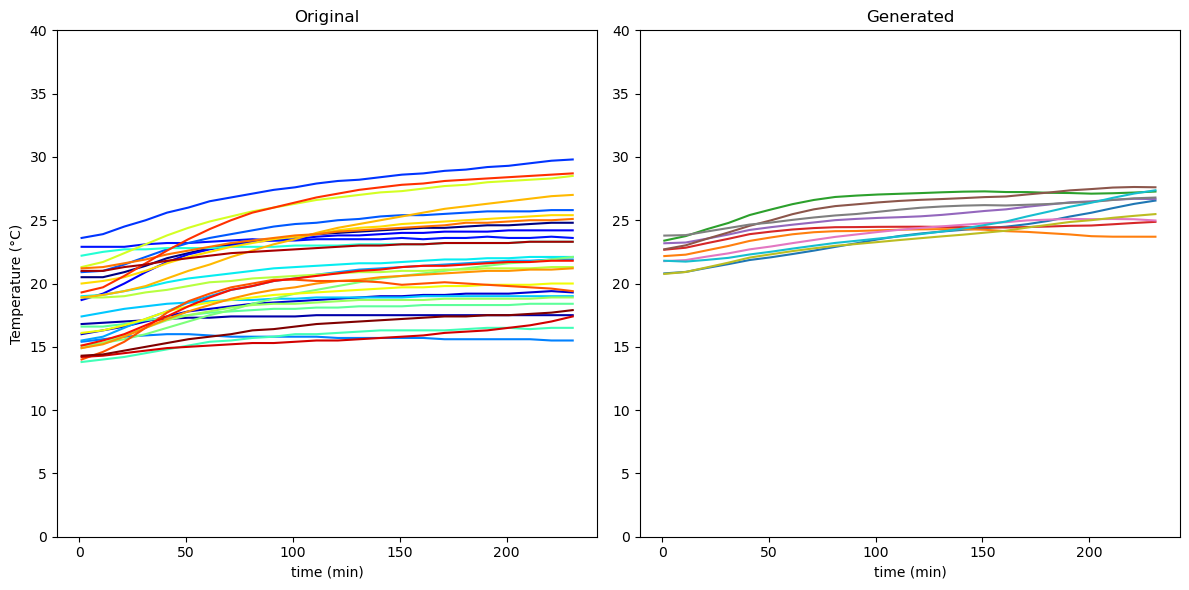

Training Progress: 100%|██████████| 5000/5000 [05:01<00:00, 16.59it/s]


In [6]:
beta = 0.01
num_epochs = 5000
torch.manual_seed(123)
metrics = model.fit(train_loader, val_loader, 
                    opt, beta, num_epochs, 
                    t_uni=t_uni/240, 
                    num_samples=10, 
                    ylim=(0,40), 
                    df=df_h, 
                    plot=True)# model.fit(train_loader, val_loader, opt, beta, num_epochs)

In [ ]:
# torch.save(model.state_dict(), 'pre_trained_models/GPVAE_heating.pth')